In [21]:
# Imports
import os
import logging
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import datetime
from scipy import stats

In [22]:
# Load the dataset
df = pd.read_csv("marketing_campaign.csv", sep="\t")

In [23]:
# Initial Data Validation and Inspection ---
print("--- DataFrame Shape and Structure ---")
print(f"Shape (Rows, Columns): {df.shape}")
df.info()

--- DataFrame Shape and Structure ---
Shape (Rows, Columns): (2240, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds    

In [24]:
#  Data Cleaning & Imputation
df["Income"] = pd.to_numeric(df["Income"], errors="coerce")
df["Income"] = df.groupby("Education")["Income"].transform(lambda x: x.fillna(x.mean()))
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")

In [25]:
# Validation Check (Post-Cleaning) 
print("\n--- Validation: Missing Values After Imputation ---")
remaining_missing = df.isnull().sum()[df.isnull().sum() > 0]

if remaining_missing.empty:
    print(" Success: No missing values remain in the DataFrame.")
else:
    print(" Warning: Remaining missing values:\n" + remaining_missing.to_markdown())


--- Validation: Missing Values After Imputation ---
 Success: No missing values remain in the DataFrame.


In [26]:
# Feature Engineering and Initial Outlier Handling 

CURRENT_YEAR = datetime.datetime.now().year
df["Age"] = CURRENT_YEAR - df["Year_Birth"]

# Spending columns
spend_cols = [c for c in df.columns if c.startswith("Mnt")]
df["TotalSpend"] = df[spend_cols].sum(axis=1)

# Family Size
df["FamilySize"] = df["Kidhome"] + df["Teenhome"]

# Accepted campaigns
cmp_cols = [c for c in df.columns if c.startswith("AcceptedCmp")]
df["TotalAccepted"] = df[cmp_cols].sum(axis=1)

# Clean marital status
df["Living_Status"] = df["Marital_Status"].replace({
    "Divorced": "Single", "Widow": "Single", "Alone": "Single",
    "YOLO": "Single", "Absurd": "Single",
    "Together": "Partner", "Married": "Partner"
})
df.drop("Marital_Status", axis=1, inplace=True)

logging.info("Feature engineering complete.")

In [27]:
# Outlier Removal
initial = len(df)
df_filtered = df[(df["Year_Birth"] >= 1945) & (df["Income"] <= 200000)].copy()
removed = initial - len(df_filtered)

logging.info(f"Removed {removed} outliers. Final dataset size: {len(df_filtered)}")

In [28]:
# Final Feature Selection and Scaling (Matrix Approach) ---

features = ["Income", "TotalSpend"]
X_matrix = df_filtered[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_matrix)

logging.info("Data scaled successfully.")


Calculating Inertia for K=1 to K=10 (2 Features)...


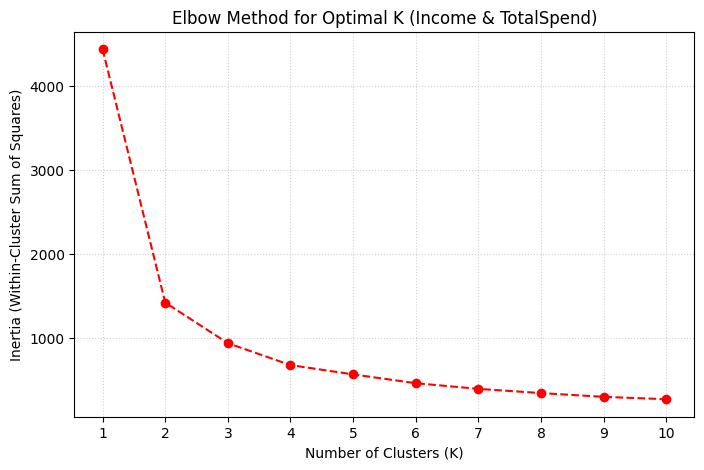

In [29]:
# Optimal K Determination (Elbow Method for 2D) 

inertia_list = []
k_range = range(1, 11)

print("\nCalculating Inertia for K=1 to K=10 (2 Features)...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)  
    inertia_list.append(kmeans.inertia_)

    
# Visualization (Elbow Plot for 2D)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_list, marker='o', linestyle='--', color='red')
plt.title('Elbow Method for Optimal K (Income & TotalSpend)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(k_range)
plt.show()

In [30]:
#  Final K-Means Execution
K = 2
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_final = df_filtered.reset_index(drop=True).copy()
df_final["Cluster_ID"] = cluster_labels


In [31]:
# Clustering Metrics

sil = silhouette_score(X_scaled, cluster_labels)
dbi = davies_bouldin_score(X_scaled, cluster_labels)

print("\n--- FINAL Clustering Performance (K=2) ---")
print(f"Silhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}\n")


--- FINAL Clustering Performance (K=2) ---
Silhouette Score: 0.589
Davies-Bouldin Index: 0.586



In [32]:
# Cluster Profiling 

cluster_profile = df_final.groupby("Cluster_ID").agg(
    Customers=("Cluster_ID", "size"),
    Avg_Income=("Income", "mean"),
    Avg_TotalSpend=("TotalSpend", "mean"),
    Avg_TotalAccepted=("TotalAccepted", "mean"),
    Avg_Age=("Age", "mean"),
    Avg_FamilySize=("FamilySize", "mean"),
).reset_index()

print("Cluster Profiles (K=2) ")
print(cluster_profile.to_markdown(index=False))

Cluster Profiles (K=2) 
|   Cluster_ID |   Customers |   Avg_Income |   Avg_TotalSpend |   Avg_TotalAccepted |   Avg_Age |   Avg_FamilySize |
|-------------:|------------:|-------------:|-----------------:|--------------------:|----------:|-----------------:|
|            0 |         900 |      72390.4 |         1225.26  |            0.578889 |   57.6656 |         0.553333 |
|            1 |        1320 |      37888.9 |          177.636 |            0.102273 |   54.7235 |         1.23333  |


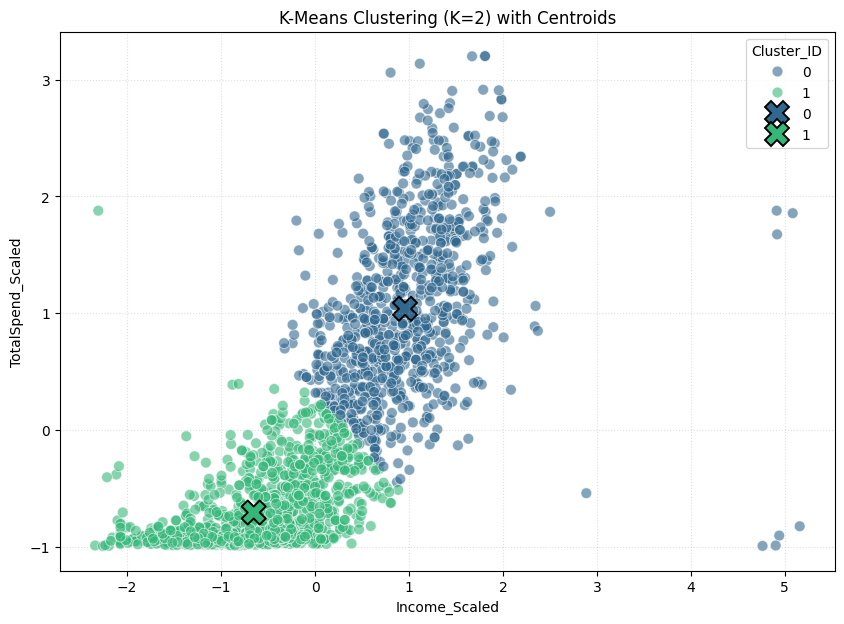

In [33]:
# Visualization (Centroids)

df_plot = df_final.copy()
df_plot["Income_Scaled"] = X_scaled[:, 0]
df_plot["TotalSpend_Scaled"] = X_scaled[:, 1]

centroids_scaled = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids_scaled, columns=["Income_Scaled", "TotalSpend_Scaled"])
centroids_df["Cluster_ID"] = centroids_df.index

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_plot, x="Income_Scaled", y="TotalSpend_Scaled",
    hue="Cluster_ID", palette="viridis", alpha=0.6, s=60
)
sns.scatterplot(
    data=centroids_df, x="Income_Scaled", y="TotalSpend_Scaled",
    hue="Cluster_ID", palette="viridis", s=300, marker="X", edgecolor="black"
)
plt.title(f"K-Means Clustering (K={K}) with Centroids")
plt.grid(True, linestyle=":", alpha=0.4)
plt.show()

In [34]:
# Statistical Significance Test (ANOVA)
print("\n--- Statistical Significance Test (ANOVA) ---")

groups = [df_final[df_final["Cluster_ID"] == i]["TotalSpend"] for i in range(K)]
f_stat, p_val = stats.f_oneway(*groups)

print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_val:.8f}")

if p_val < 0.05:
    print("Conclusion: Cluster differences ARE statistically significant.")
else:
    print("Conclusion: Cluster differences are NOT statistically significant.")

print(" PROJECT COMPLETED SUCCESSFULLY (K=2 Optimized)")


--- Statistical Significance Test (ANOVA) ---
F-Statistic: 6094.69
P-Value: 0.00000000
Conclusion: Cluster differences ARE statistically significant.
 PROJECT COMPLETED SUCCESSFULLY (K=2 Optimized)


In [35]:
#  Final Business Interpretation and Strategy (K=2)

print("\n--- FINAL BUSINESS INTERPRETATION AND STRATEGY (K=2) ---")

# Determine which Cluster ID is High-Value based on Avg_TotalSpend (safely locate the ID)
# We find the ID corresponding to the maximum spend row.
high_value_id = cluster_profile.loc[cluster_profile['Avg_TotalSpend'].idxmax(), 'Cluster_ID']
low_value_id = cluster_profile.loc[cluster_profile['Avg_TotalSpend'].idxmin(), 'Cluster_ID']

print(f"\n### Segment {high_value_id}: The 'High-Value/Affluent' Core")
print(f"* **Size:** {cluster_profile.loc[cluster_profile['Cluster_ID'] == high_value_id, 'Customers'].values[0]} customers")
print("* **Profile:** These customers drive the majority of the revenue. They have significantly **Higher Income** and **Total Spend**.")
print("* **Strategy:** **Retention and Premiumization.** Focus on loyalty programs, exclusive offers, personalized high-end product recommendations, and ensuring high-touch customer service. Maximize Customer Lifetime Value (CLV).")

print(f"\n### Segment {low_value_id}: The 'Budget/Low-Engagement' Majority")
print(f"* **Size:** {cluster_profile.loc[cluster_profile['Cluster_ID'] == low_value_id, 'Customers'].values[0]} customers")
print("* **Profile:** This group forms the largest part of the market with generally **Lower Income** and minimal **Total Spend**.")
print("* **Strategy:** **Acquisition and Efficiency.** Focus on cost-effective digital campaigns (email, social), value-oriented pricing, and converting them with entry-level products. Avoid expensive direct marketing spend.")

print("\n--- PROJECT FULLY COMPLETE ---")


--- FINAL BUSINESS INTERPRETATION AND STRATEGY (K=2) ---

### Segment 0: The 'High-Value/Affluent' Core
* **Size:** 900 customers
* **Profile:** These customers drive the majority of the revenue. They have significantly **Higher Income** and **Total Spend**.
* **Strategy:** **Retention and Premiumization.** Focus on loyalty programs, exclusive offers, personalized high-end product recommendations, and ensuring high-touch customer service. Maximize Customer Lifetime Value (CLV).

### Segment 1: The 'Budget/Low-Engagement' Majority
* **Size:** 1320 customers
* **Profile:** This group forms the largest part of the market with generally **Lower Income** and minimal **Total Spend**.
* **Strategy:** **Acquisition and Efficiency.** Focus on cost-effective digital campaigns (email, social), value-oriented pricing, and converting them with entry-level products. Avoid expensive direct marketing spend.

--- PROJECT FULLY COMPLETE ---
